In [1]:
import numpy as np
import pandas as pd
import os

from bec import *
from monet import *
import al_utils
from pathlib import Path


import warnings
warnings.filterwarnings('ignore')

np.random.seed(69)

In [3]:
#Function to return solution of the equation
def nls_exact(x, t, k, mu, alp):
    return k * np.sqrt(2/mu) / (np.cosh(k*(x - 2*alp*t)) * np.exp(1j * (alp*x - (alp**2-k**2) * t)))

x = np.linspace(-25., 25., 512)
t = np.linspace(-20., 20., 300)

X, T = np.meshgrid(x, t)

k, mu, alp = 0.5, 1., 0.2

ans = np.array(nls_exact(np.ravel(X), np.ravel(T), k, mu, alp))
sol = np.abs(ans.reshape(X.shape))

def data_nls(x,t,sol):
    df = pd.DataFrame({
    'x' : x,
    'g' : t,
    'psi' : sol
    })
    return df

In [26]:
sample = [ data_nls(X[i,:],T[i,:],sol[i,:]) for i in range(0,300)]
tr, te, va = make_dataset(sample)
print(f"### Created Train, Test and Validation Sample")
gp = GPApproximation()
data = tr.sample(500)
gp.fit(data[['x', 'g']], data.psi)
print(f"### Trained GP in train dataset")

### Created Train, Test and Validation Sample
### Trained GP in train dataset


In [27]:
def evaluate(gp, sample, low=1, high=100, n=100):
    
    def _evaluate(g):
        gt = get_closest_sim(sample, g)
        pr, pr_sigma = gp.predict(gt[['x', 'g']])
        return ((pr - gt.psi)**2).sum().mean()
    
    return np.array([_evaluate(g) for g in np.linspace(low, high, n)]).mean()

In [28]:
nls_loss = evaluate(gp, sample, low=15, high=20)
print(f"### Loss of the trained GP - {nls_loss}")

### Loss of the trained GP - 0.023445603546574212


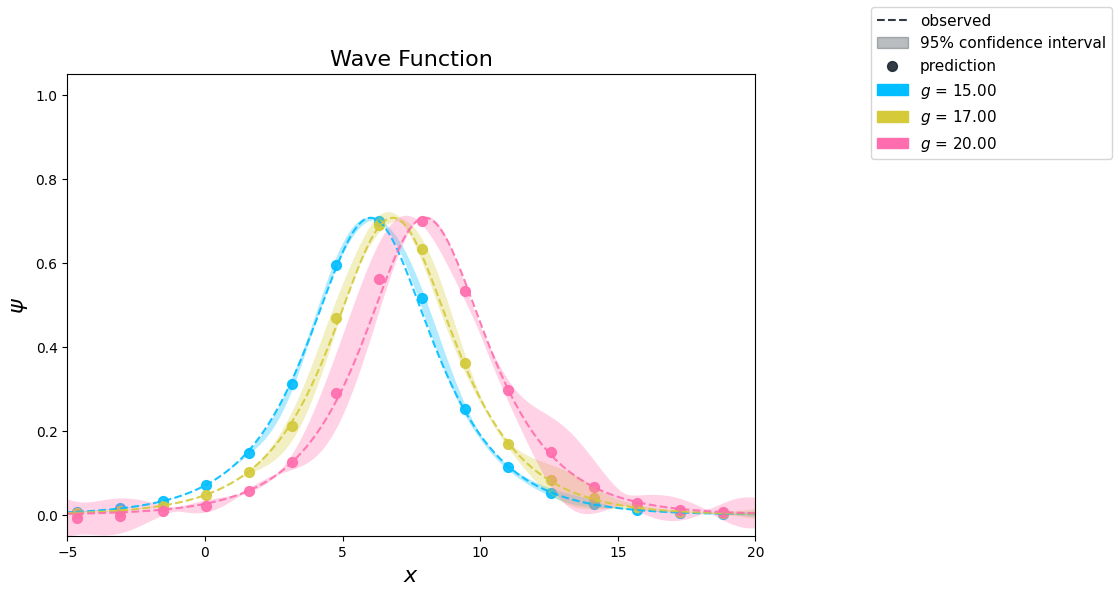

In [29]:
save_path = "NLS_exp"
if os.path.isdir(save_path) == False:
    os.mkdir(save_path)
al_utils.plot([15, 17, 20], sample, gp, save_file=os.path.join(save_path, f'{save_path}.svg'), act_op=False, min_gs=-5, max_gs=20)

###Starting active learning Process
Loss for 51 - nan
Got min loss
Loss for 52 - 9.636525858711957
Got min loss
Loss for 53 - 7.44573018181333
Loss for 54 - 7.572698378780983
Loss for 55 - 7.5512830614752655
Got min loss
Loss for 56 - 4.535335951632492
Got min loss
Loss for 57 - 4.452998250728695
Got min loss
Loss for 58 - 4.440701040884305
Got min loss
Loss for 59 - 4.197787842916609
Loss for 60 - 4.39144528189394
Loss for 61 - 4.210471001016673


KeyboardInterrupt: 

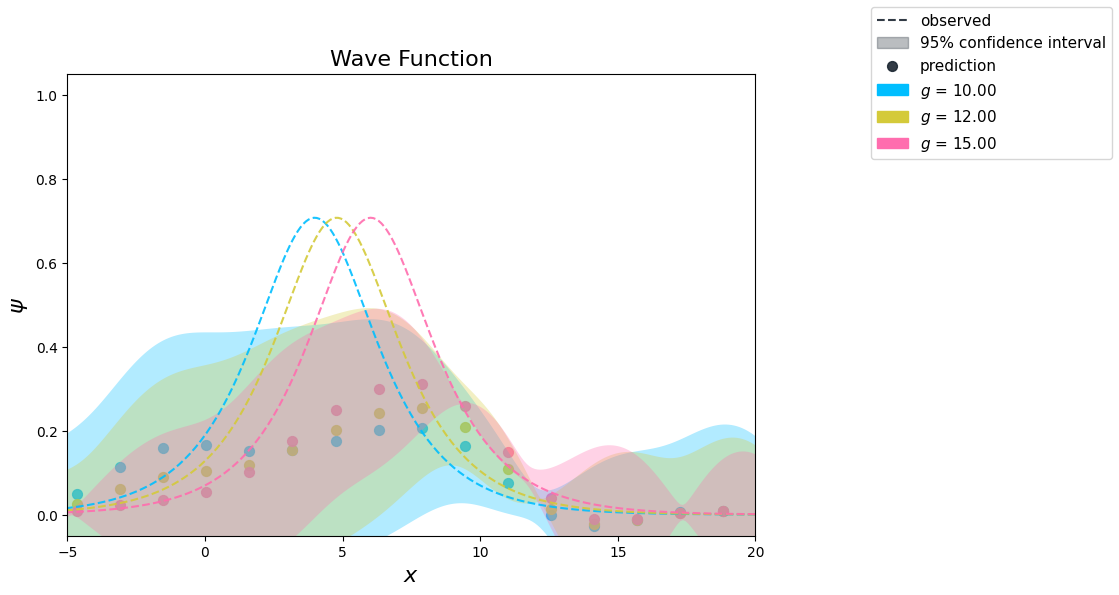

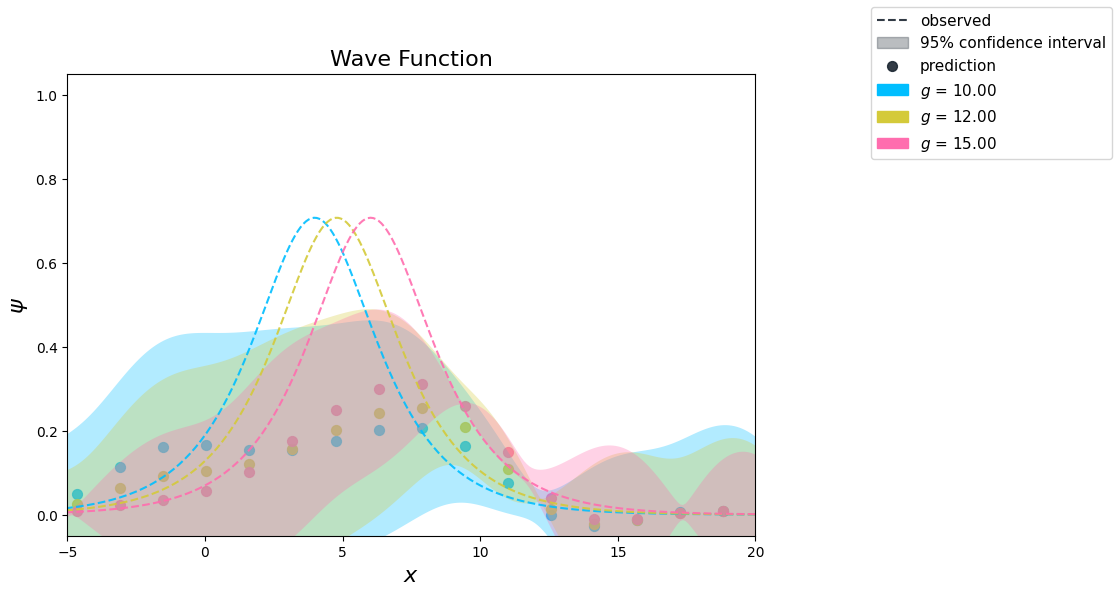

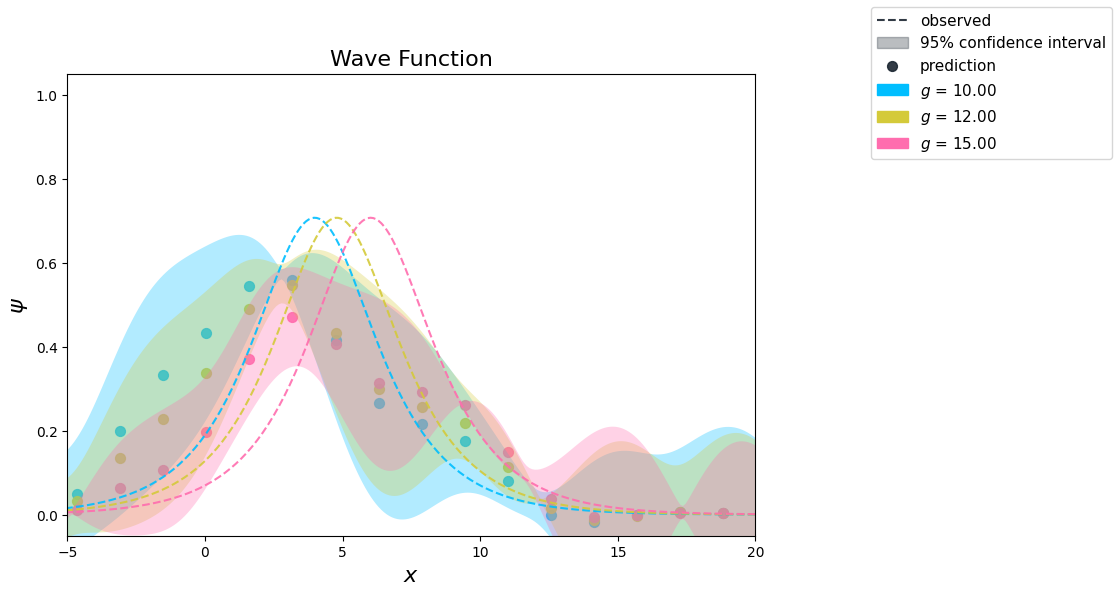

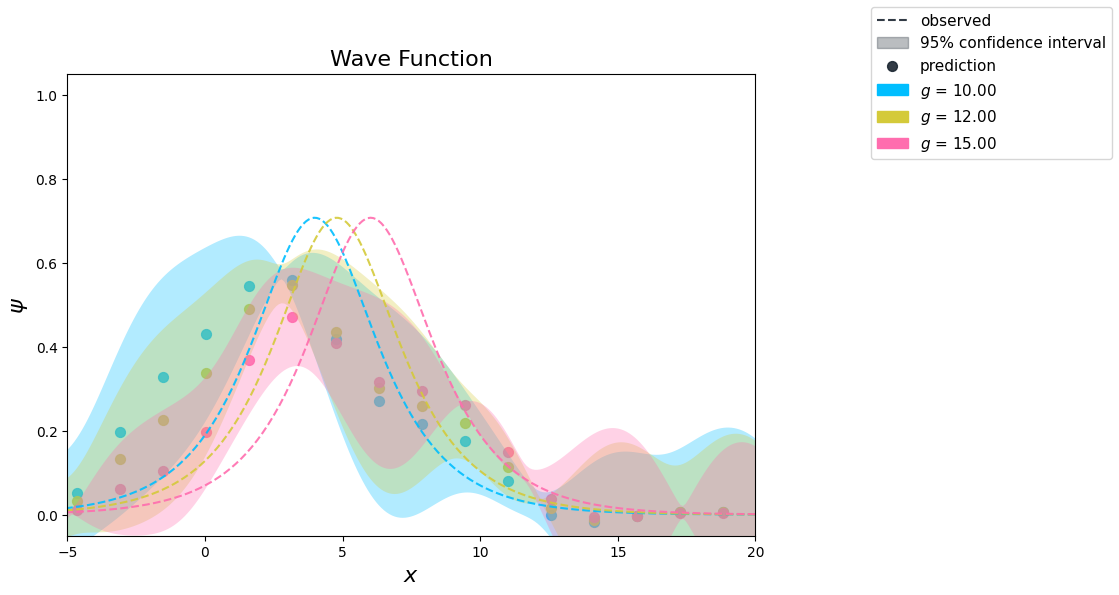

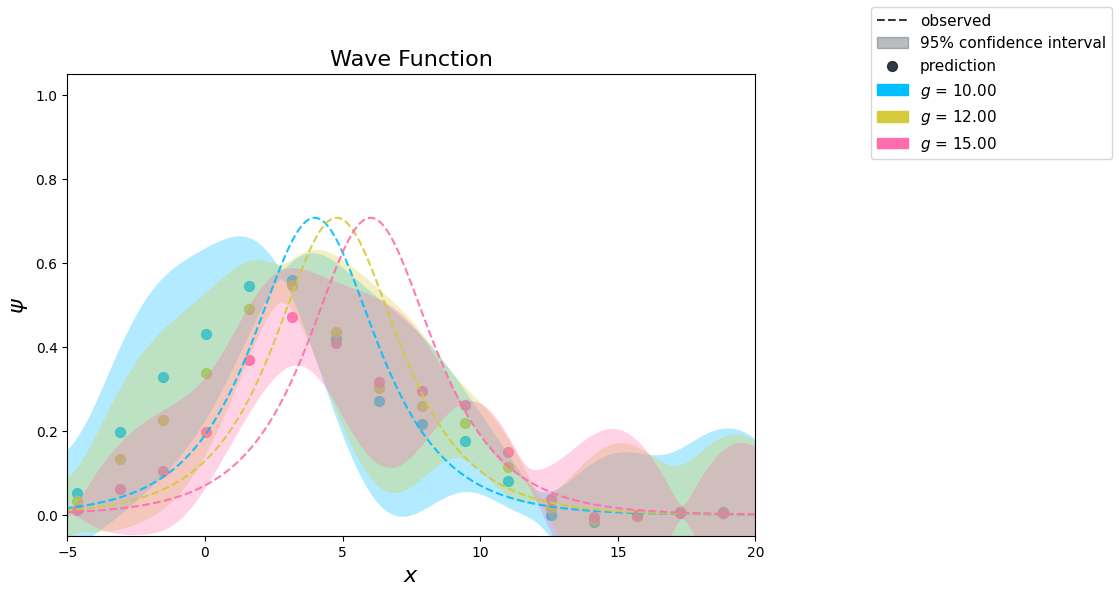

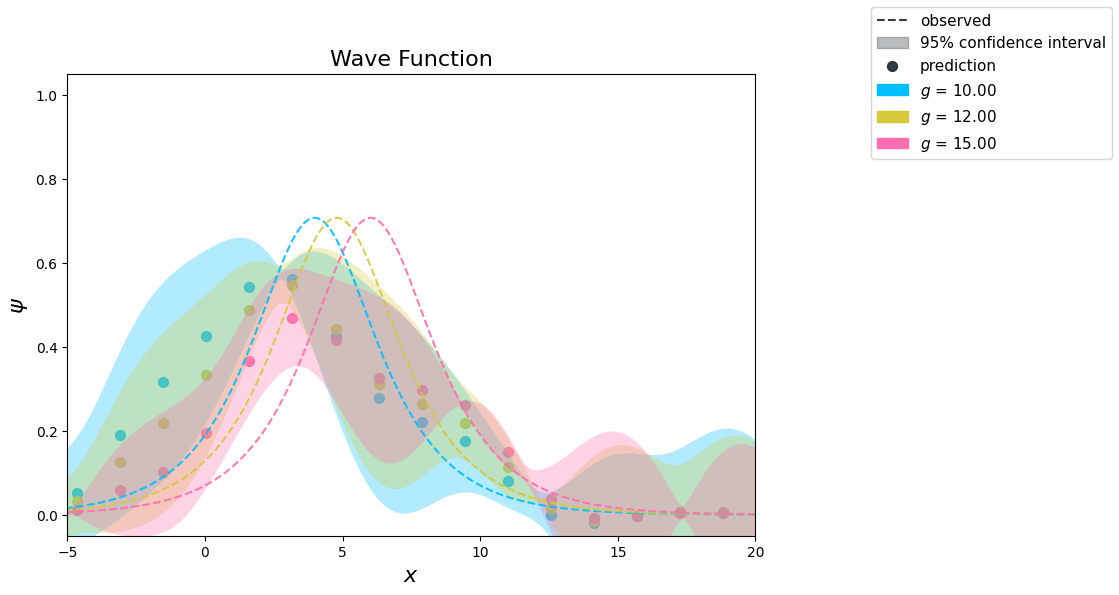

In [21]:
print(f"###Starting active learning Process")
kernel = C(1.0, (1e-3, 1e3)) * RBF([5, 5], (1e-2, 1e2))
regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
ids = [int(i) for i in np.linspace(0, len(tr)-1, 50)]
aclrnr = al_utils.ActLearn(
    regressor=regressor,
    init_ids=ids,
    trn_data=tr,
    save_path=save_path,
    compare_loss=nls_loss,
    exp_name='NLS'
)

aclrnr.train(sample, low=10, high=15, gs=[10, 12, 15], min_gs=-5, max_gs=20)

